# WESM Price Prediction - EDA

# Setup and Loading

This loads the final dataset. Further description is found below.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

df = pd.read_csv("final_dataset.csv")
df["datetime"] = pd.to_datetime(df["datetime"])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15836 entries, 0 to 15835
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            15836 non-null  datetime64[ns]
 1   GWAP                15836 non-null  float64       
 2   energy_demand_mw    15836 non-null  float64       
 3   energy_supply_mw    15836 non-null  float64       
 4   energy_shortage_mw  15836 non-null  float64       
 5   reserve_demand_mw   15836 non-null  float64       
 6   reserve_supply_mw   15836 non-null  float64       
 7   outage_count        15836 non-null  float64       
 8   GWAP_Lag_1          15836 non-null  float64       
 9   GWAP_Lag_12         15836 non-null  float64       
 10  GWAP_Lag_288        15836 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 1.3 MB
None


# I. Dataset Description

### The Data

The final dataset is generated from ETL Processing which combines data from three different catagories, **GWAP**, **RTD Regional Summaries**, and **Outage Schedules**. The columns are defined as follows:

- `datetime`: Target End Time of Dispatch Interval
- `GWAP`: Generator Weighted Average Price
- `energy_demand_mw`: MW Requirement for Energy
- `energy_supply_mw`: MW Generation for Energy
- `energy_shortage_mw`: MW difference between energy demand and supply 
    - Serves as an indicator of potential load shedding or brownouts.
- `reserve_demand_mw`: MW Requirement for Reserve Commodities (Non-energy commodity type)
- `reserve_supply_mw`: MW Generation for Reserve Commodities (Non-energy commodity type)
- `outage_count`: Count of outages per datetime
    - Value of 0 - No outages occured at timestamp
- `GWAP_Lag_1`: GWAP value 5 minutes ago
- `GWAP_Lag_12`: GWAP value 1 hour ago
- `GWAP_Lag_288`: GWAP value at the same time yesterday (24 hours ago)

In [3]:
print(df.describe())
print(df.head())

                            datetime          GWAP  energy_demand_mw  \
count                          15836  15836.000000      15836.000000   
mean   2025-11-28 12:07:38.297550080   3056.098671       9263.982652   
min              2025-11-01 00:05:00  -9999.000000       5034.010000   
25%              2025-11-14 18:13:45   2041.219300       8249.792500   
50%              2025-11-28 12:07:30   2628.059850       9231.965000   
75%              2025-12-12 06:01:15   3956.551925      10346.900000   
max              2025-12-26 00:00:00  31997.080000      11992.110000   
std                              NaN   2777.625859       1272.408255   

       energy_supply_mw  energy_shortage_mw  reserve_demand_mw  \
count      15836.000000        15836.000000       15836.000000   
mean        9557.343018         -293.360367        1535.128063   
min         5096.560000         -761.620000         940.000000   
25%         8583.912500         -433.387500        1424.000000   
50%         9544.5000

As seen above, the minimum GWAP recorded is -9999. Initially, we thought this was a sentinel value (error code) but after observing neighboring data points (e.g., -9998 and -9500) and reading the [WESM Price Determination Methodology](https://www.wesm.ph/downloads/download/TWFya2V0IFJlcG9ydHM=/NTYw), we were able to determine that these were valid data.

According to the WESM Price Determination Methodology, this phenomenon is driven by "Excess Generation", where the market clears at or near the Offer Price Floor (currently set at -P10,000/MWh).
> "5.4.2 In the event of over-generation, the excess price shall be determined as the offer price floor."

The Logic:
- Over-generation: Happens when Supply > Demand.
- "Pay-to-Stay" Strategy: the -9,999 (just P1.00 above the floor) implies a strategic bid. Baseload generators (like Coal) have high startup costs, so they bid highly negative prices (essentially paying the market to keep running) rather than shutting down.
- The Result: The -9999.0 GWAP confirms that the grid was saturated enough to force prices down to the "desperation bids" of the large plants.

Further, we can also observe that our data started **November 01, 2025** and ended **December 26, 2025**.

# II. Data Cleaning

### Check for Duplicates

Each row in the dataset is unique as its data is recorded every five minutes from November to December of the year 2025. This check is done to validate that there are no duplicate data, rows whose values are identical to another. As the results display an empty dataframe, this means that there were no duplicates found.

In [4]:
duplicates = df[df.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [datetime, GWAP, energy_demand_mw, energy_supply_mw, energy_shortage_mw, reserve_demand_mw, reserve_supply_mw, outage_count, GWAP_Lag_1, GWAP_Lag_12, GWAP_Lag_288]
Index: []


### Check for Missing Values

Although missing data from columns such as `outage_count` and those that resulted from the creation of the **lag feature** have already been handled during ETL Processing, this check is to validate that there are no other missing values in the dataset. As seen below, there appears to be no other values missing.

In [5]:
df.isnull().sum()

datetime              0
GWAP                  0
energy_demand_mw      0
energy_supply_mw      0
energy_shortage_mw    0
reserve_demand_mw     0
reserve_supply_mw     0
outage_count          0
GWAP_Lag_1            0
GWAP_Lag_12           0
GWAP_Lag_288          0
dtype: int64

### Check for Inconsistent Data Type

This check is to see if the data types for each column are consistent. All coulmns are shown to have consistent data types across the entire dataset.

In [6]:
df.dtypes

datetime              datetime64[ns]
GWAP                         float64
energy_demand_mw             float64
energy_supply_mw             float64
energy_shortage_mw           float64
reserve_demand_mw            float64
reserve_supply_mw            float64
outage_count                 float64
GWAP_Lag_1                   float64
GWAP_Lag_12                  float64
GWAP_Lag_288                 float64
dtype: object

In [7]:
flag = False

for col in df.columns:
    types = df[col].apply(type).nunique()
    if types > 1:
        print(f"Column '{col}' has multiple data types.")
        flag = True

if not flag:
    print(f"Dataset has consistent data types in each column.")

Dataset has consistent data types in each column.


### Check for Outliers

*not sure if we're going to drop outliers*

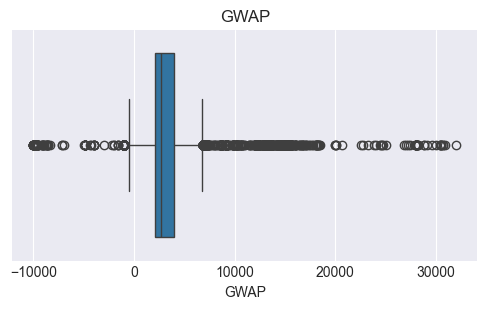

In [8]:
GWAP = df['GWAP']

plt.figure(figsize=(6, 3))
sns.boxplot(x=GWAP)
plt.title('GWAP')
plt.show()

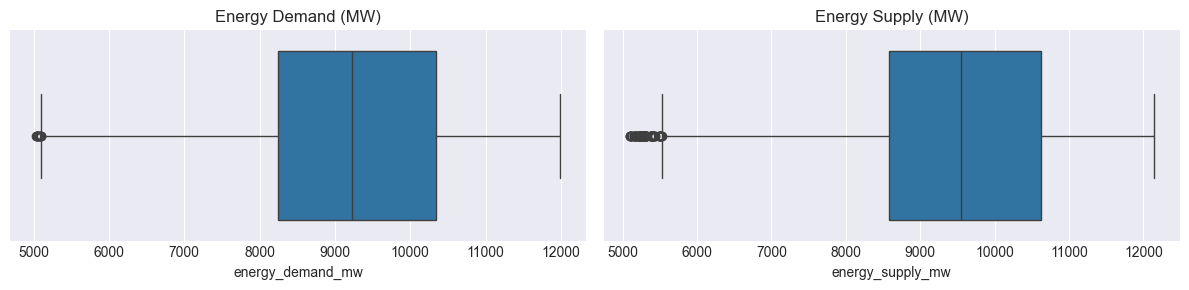

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

sns.boxplot(x=df['energy_demand_mw'], ax=axes[0])
axes[0].set_title('Energy Demand (MW)')

sns.boxplot(x=df['energy_supply_mw'], ax=axes[1])
axes[1].set_title('Energy Supply (MW)')

plt.tight_layout()
plt.show()

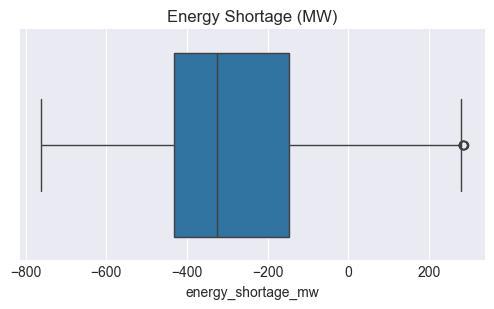

In [10]:
energy_shortage_mw = df['energy_shortage_mw']

plt.figure(figsize=(6, 3))
sns.boxplot(x=energy_shortage_mw)
plt.title('Energy Shortage (MW)')
plt.show()

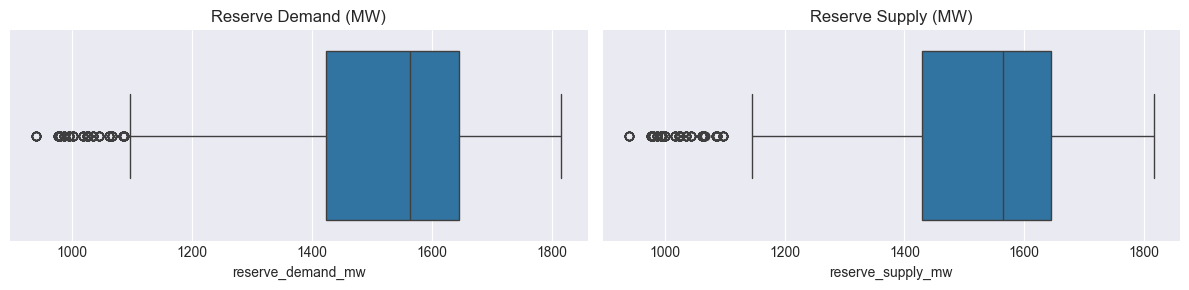

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

sns.boxplot(x=df['reserve_demand_mw'], ax=axes[0])
axes[0].set_title('Reserve Demand (MW)')

sns.boxplot(x=df['reserve_supply_mw'], ax=axes[1])
axes[1].set_title('Reserve Supply (MW)')

plt.tight_layout()
plt.show()

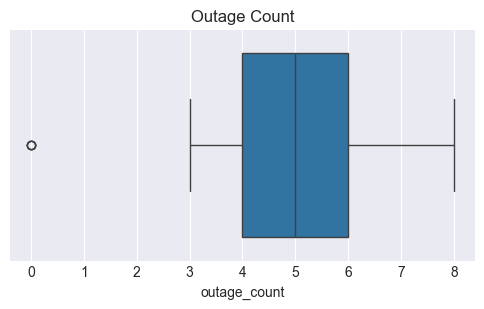

In [12]:
outage_count = df['outage_count']

plt.figure(figsize=(6, 3))
sns.boxplot(x=outage_count)
plt.title('Outage Count')
plt.show()

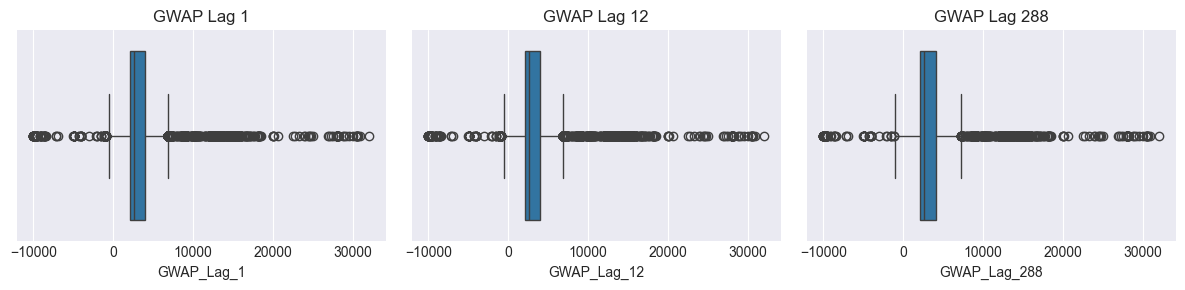

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

sns.boxplot(x=df['GWAP_Lag_1'], ax=axes[0])
axes[0].set_title('GWAP Lag 1')

sns.boxplot(x=df['GWAP_Lag_12'], ax=axes[1])
axes[1].set_title('GWAP Lag 12')

sns.boxplot(x=df['GWAP_Lag_288'], ax=axes[2])
axes[2].set_title('GWAP Lag 288')

plt.tight_layout()
plt.show()

# III. EDAs

## EDA 1: GWAP

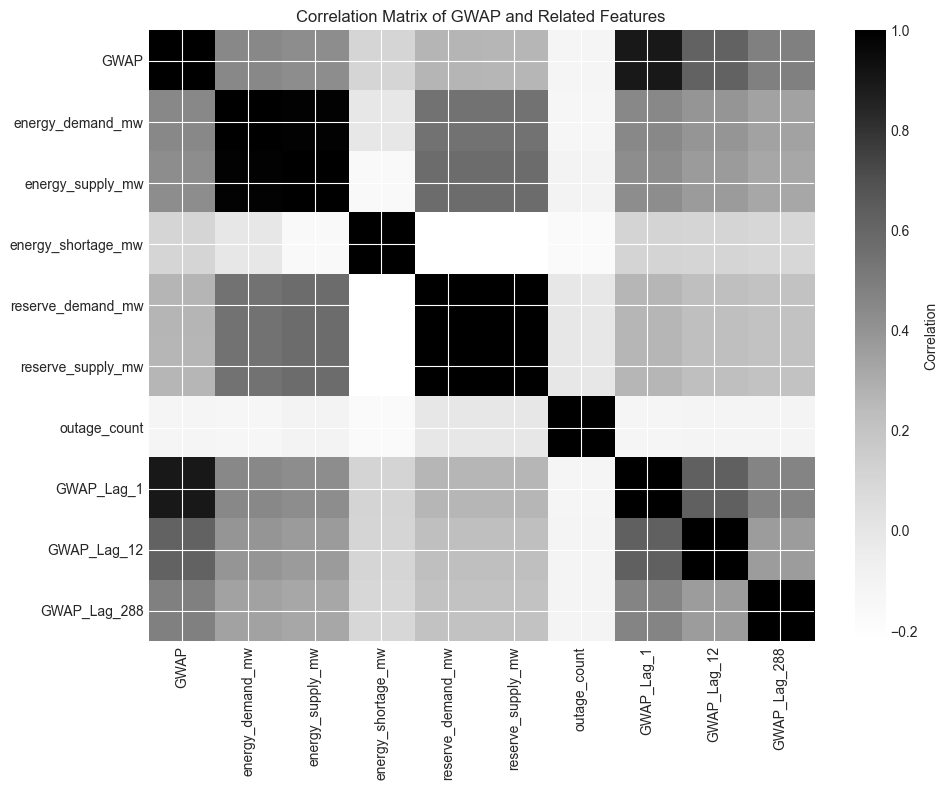

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Select numeric columns only
corr = df.select_dtypes(include="number").corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.colorbar(label="Correlation")

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.title("Correlation Matrix of GWAP and Related Features")
plt.tight_layout()
plt.show()

## EDA 2: Energy Supply and Energy Demand

**EDA Question**: What is the relationship between energy supply and demand? 

**Follow up Questions**:
* What is the effect of supply and demand in GWAP?

The scatter plot shows a near-perfect linear relationship between energy demand and energy supply. Most points lie close to the 45-degree line, indicating that **supply closely tracks demand across time**. This suggests that the power system is generally balanced, with supply being adjusted to meet demand. Minor deviations from the diagonal represent imbalances, which may be influenced by operational constraints.

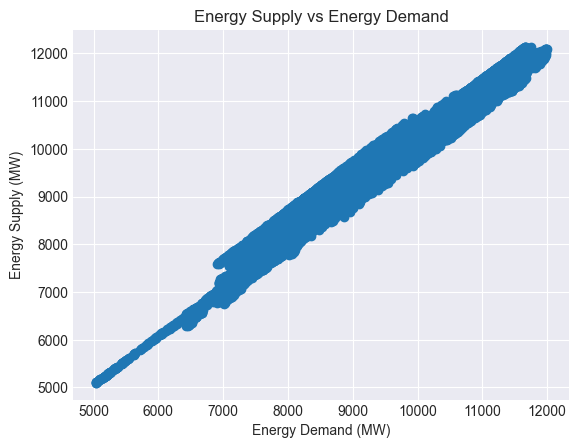

In [15]:
plt.figure()
plt.scatter(df["energy_demand_mw"], df["energy_supply_mw"])
plt.xlabel("Energy Demand (MW)")
plt.ylabel("Energy Supply (MW)")
plt.title("Energy Supply vs Energy Demand")
plt.show()

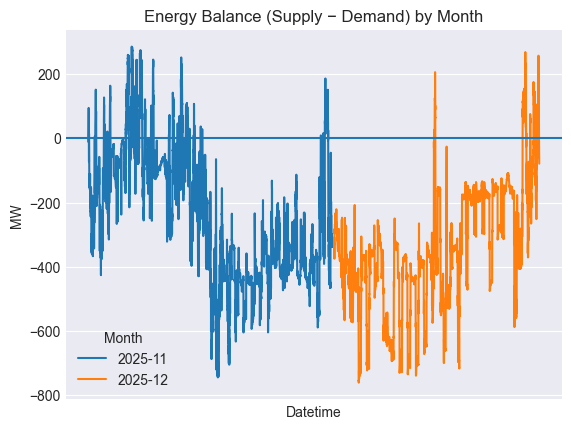

In [ ]:
df["month_year"] = df["datetime"].dt.to_period("M").astype(str)

plt.figure()

for month, g in df.groupby("month_year"):
    plt.plot(
        g["datetime"],
        g["energy_shortage_mw"],
        label=month
    )

plt.axhline(0)
plt.xlabel("Datetime")
plt.xticks([]) 
plt.ylabel("MW")
plt.title("Energy Balance by Month")
plt.legend(title="Month")
plt.show()

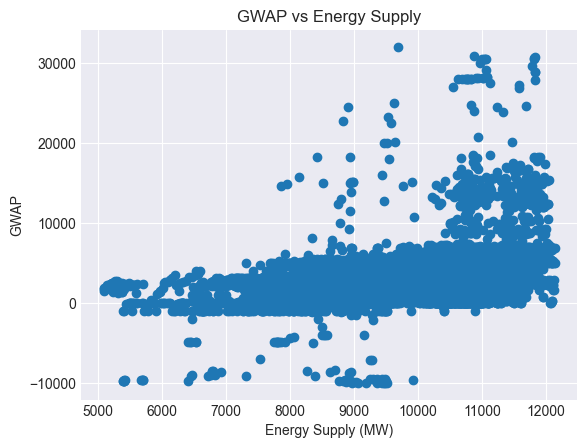

Correlation between energy supply and GWAP: 0.427


In [ ]:
# Scatter plot: Energy Supply vs GWAP
plt.figure()
plt.scatter(df["energy_supply_mw"], df["GWAP"])
plt.xlabel("Energy Supply (MW)")
plt.ylabel("GWAP")
plt.title("GWAP vs Energy Supply")
plt.show()

# Optional: correlation check
correlation = df["energy_supply_mw"].corr(df["GWAP"])
print(f"Correlation between energy supply and GWAP: {correlation:.3f}")

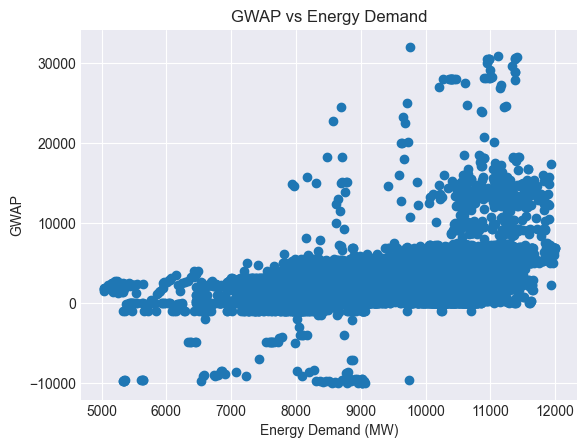

Correlation between energy demand and GWAP: 0.451


In [ ]:
# Scatter plot: Energy Supply vs GWAP
plt.figure()
plt.scatter(df["energy_demand_mw"], df["GWAP"])
plt.xlabel("Energy Demand (MW)")
plt.ylabel("GWAP")
plt.title("GWAP vs Energy Demand")
plt.show()

# Optional: correlation check
correlation = df["energy_demand_mw"].corr(df["GWAP"])
print(f"Correlation between energy demand and GWAP: {correlation:.3f}")